In [2]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../GGH')

from GGH.data_ops import DataOperator
from GGH.selection_algorithms import AlgoModulators
from GGH.models import initialize_model, Autoencoder
from GGH.train_val_loop import TrainValidationManager
from GGH.inspector import Inspector, plot_histogram, visualize_train_val_error, selection_histograms, create_heatmap, cluster_and_visualize, \
                            get_gradarrays_n_labels, prep_tsne_min_max_ranges, sep_grads_by_labels
from GGH.imputation_methods import Imputer
import warnings
warnings.filterwarnings('ignore')

def full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, results_path, dropout = 0.05, lr = 0.004, nu = 0.1,
                    normalize_grads_contx = False, use_context = True, final_analysis = False):
       
    AM = AlgoModulators(DO, lr = lr, nu = nu, normalize_grads_contx = False, use_context = True, freqperc_cutoff = 0.25)
    dataloader = DO.prep_dataloader(use_info, batch_size)

    model = initialize_model(DO, dataloader, hidden_size, rand_state, dropout = dropout) 

    TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, rand_state, results_path, final_analysis = final_analysis)
    TVM.train_model(DO, AM, model, final_analysis = final_analysis)

    INSPECT.save_train_val_logs(DO, AM, TVM, model, final_analysis = final_analysis)
    
    return DO, TVM, model

def multi_experiments(total_runs, use_info, num_epochs, data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
                      INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters, final_analysis = True):
    
    progress_bar = tqdm(total=total_runs)
    for r_state in range(2000): #
        DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu")
        if not DO.lack_partial_coverage:
            full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, r_state, results_path,
                            hyperparameters["dropout"]["value"], hyperparameters["lr"]["value"], hyperparameters["nu"]["value"], final_analysis)
            progress_bar.update(1)
        if progress_bar.n == total_runs:
            break       
    progress_bar.close()

In [7]:
df = pd.read_csv('../data/donated_blood/donated_blood_subsampled_balance.csv')

<AxesSubplot:>

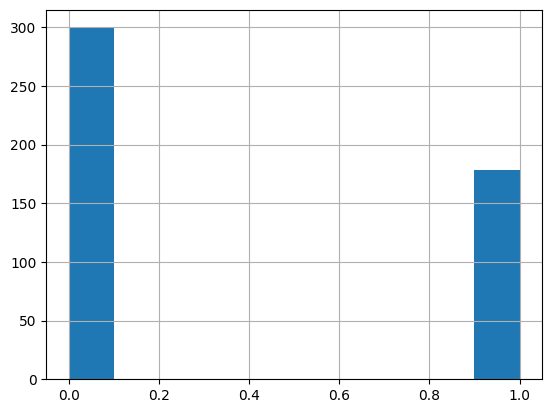

In [9]:
df.Donate_Blood.hist()

<AxesSubplot:>

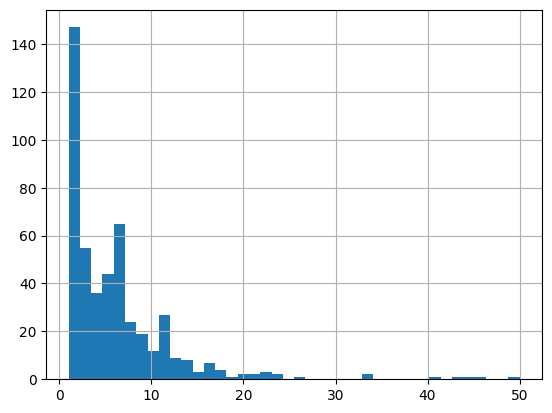

In [19]:
df["Frequency"].hist(bins = 40)

In [25]:
len(df[(df["Frequency"]>-1) & (df["Frequency"]<=1)])/len(df)

0.17782426778242677

In [3]:
#User requiered data and parameters
data_path = '../data/donated_blood/donated_blood_subsampled_balance.csv'
results_path = "../saved_results/Donated Blood"
inpt_vars = ['Recency', 'Time'] # 'chord-length',
target_vars = ['Donate_Blood']
miss_vars = ['Frequency']
hypothesis = [[1, 4, 9, 50]]

#Percentage of simulated data with full information
partial_perc = 0.80
rand_state = 42

#Model Train Parameters
hidden_size = 32

batch_size = 100*len(hypothesis[0])
output_size = len(target_vars)

#Call data, algorithm and model classes
INSPECT = Inspector(results_path, hidden_size)

100%|██████████| 40/40 [00:48<00:00,  1.21s/it]
findfont: Font family ['Cambria'] not found. Falling back to DejaVu Sans.


0.5921052631578947
0.7068965517241379
0.49426523297491043
0.6169296987087518


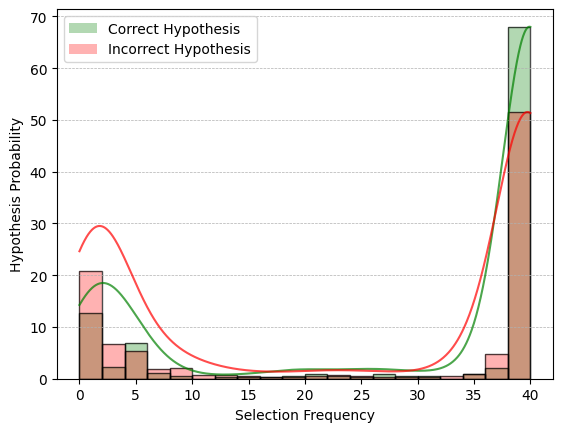

In [12]:
#partial at 5%
use_info = "use hypothesis"
num_epochs = 40
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, nu = 0.1, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_acc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_acc(DO, TVM, model, data = "test"))

print(INSPECT.calculate_val_auc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_auc(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

100%|██████████| 100/100 [03:03<00:00,  1.84s/it]


0.5921052631578947
0.7068965517241379
0.5222222222222223
0.6269727403156384


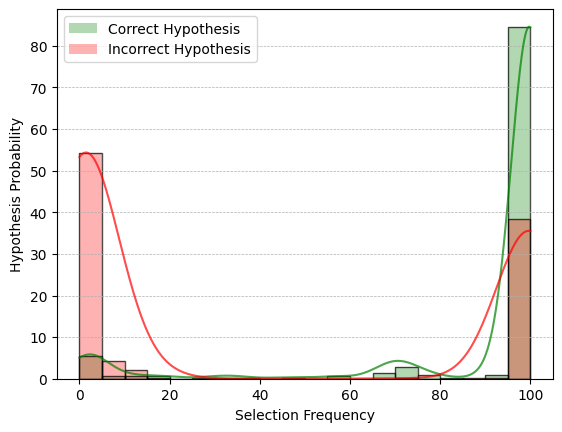

In [29]:
#partial at 25%
use_info = "use hypothesis"
num_epochs = 100

DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, nu = 0.1, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_acc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_acc(DO, TVM, model, data = "test"))

print(INSPECT.calculate_val_auc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_auc(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

100%|██████████| 100/100 [07:18<00:00,  4.38s/it]


0.5921052631578947
0.7068965517241379
0.5508960573476703
0.6513629842180775


findfont: Font family ['Cambria'] not found. Falling back to DejaVu Sans.


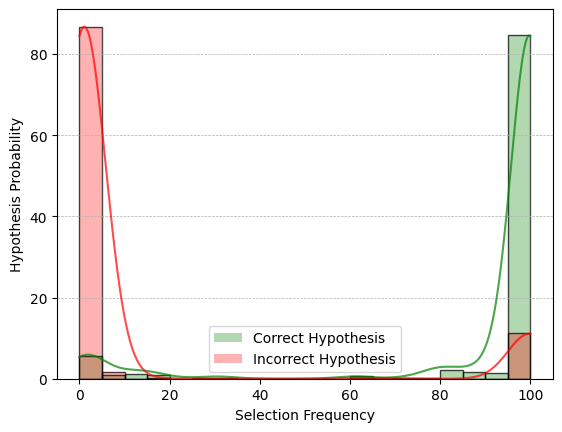

In [3]:
#partial at 80%
use_info = "use hypothesis"
num_epochs = 100

DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, nu = 0.1, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_acc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_acc(DO, TVM, model, data = "test"))

print(INSPECT.calculate_val_auc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_auc(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

100%|██████████| 500/500 [35:49<00:00,  4.30s/it]


0.5921052631578947
0.5862068965517241
0.7369175627240143
0.7732843137254902


LinAlgError: singular matrix

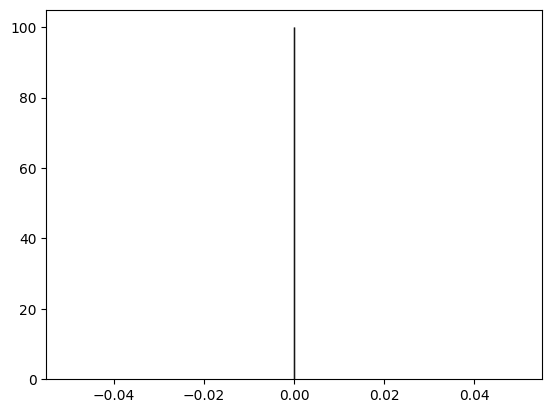

In [11]:
use_info = "use hypothesis"
num_epochs = 500

rand_state = 0

DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, nu = 0.1, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_acc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_acc(DO, TVM, model, data = "test"))

print(INSPECT.calculate_val_auc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_auc(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

In [ ]:
plt.plot(TVM.valid_errors_epoch)

100%|██████████| 30/30 [02:39<00:00,  5.32s/it]


0.5921052631578947
0.7068965517241379
0.4856630824372761
0.6068866571018651


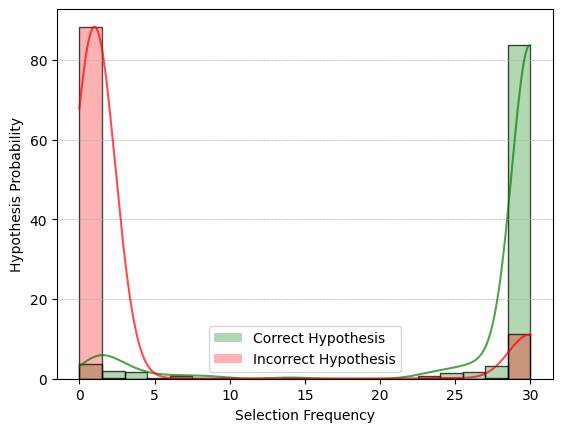

In [18]:
#partial at 80% and 64 node NN
use_info = "use hypothesis"
num_epochs = 30

DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, nu = 0.1, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_acc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_acc(DO, TVM, model, data = "test"))

print(INSPECT.calculate_val_auc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_auc(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

In [10]:
DO.problem_type

'binary-class'

In [13]:
DO.train_outcomes_tensor[:10]

AttributeError: 'DataOperator' object has no attribute 'train_outcomes_tensor'

In [19]:
DO.val_outcomes_tensor[:10]

tensor([[1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.]])

In [20]:
for batch_i, (inputs, labels) in enumerate(TVM.dataloader):
    print(labels[:10])
    break

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.]])


In [21]:
model(DO.full_val_input_tensor)[:10]

tensor([[1.1875e-04],
        [1.0086e-04],
        [6.7115e-05],
        [2.6179e-04],
        [1.1519e-05],
        [8.8351e-06],
        [4.2508e-06],
        [8.5225e-05],
        [2.9080e-04],
        [6.9650e-05]], grad_fn=<SliceBackward0>)

100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


0.6447368421052632
0.6896551724137931
0.5158730158730158
0.5604166666666667


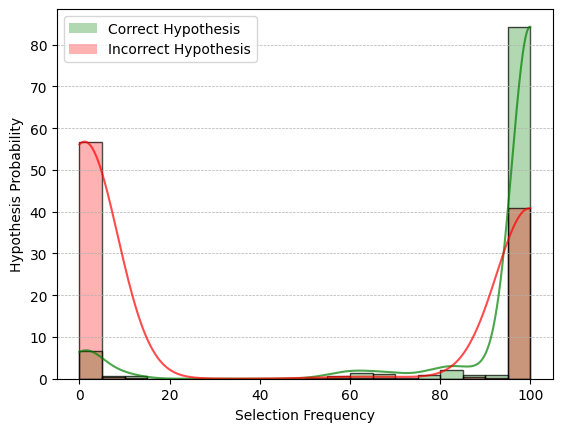

In [30]:
#partial at 25%
use_info = "use hypothesis"
num_epochs = 100

rand_state = 100

DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, nu = 0.1, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_acc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_acc(DO, TVM, model, data = "test"))

print(INSPECT.calculate_val_auc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_auc(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

100%|██████████| 100/100 [03:04<00:00,  1.85s/it]


0.5921052631578947
0.7068965517241379
0.5071684587813621
0.6226685796269726


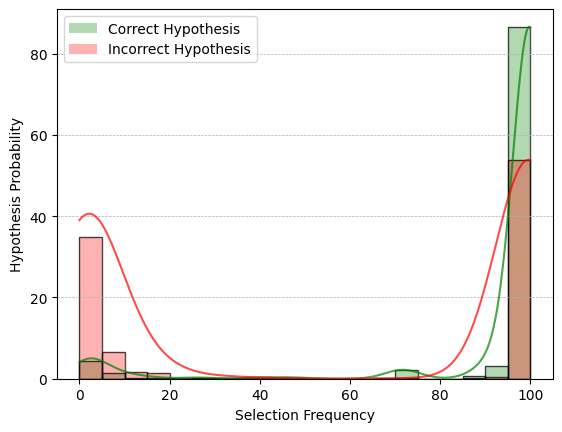

In [14]:
#partial at 25%
use_info = "use hypothesis"
num_epochs = 100
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, nu = 0.1, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_acc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_acc(DO, TVM, model, data = "test"))

print(INSPECT.calculate_val_auc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_auc(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

100%|██████████| 100/100 [03:05<00:00,  1.85s/it]


0.5921052631578947
0.7068965517241379
0.5071684587813621
0.6226685796269726


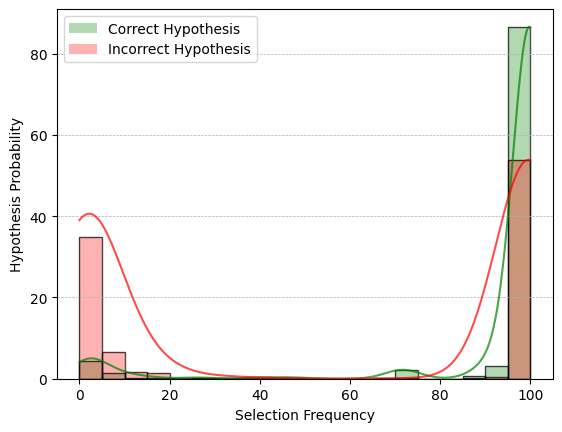

In [15]:
use_info = "use hypothesis"
num_epochs = 100
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, nu = 0.1, normalize_grads_contx = True, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_acc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_acc(DO, TVM, model, data = "test"))

print(INSPECT.calculate_val_auc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_auc(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

In [4]:
#Number of loops to ensure statistical significance
num_loops = 15
num_epochs = 200
r_state = 0
use_info = "full info"
hyperparameters = {"lr": {"value": 0.004}, "dropout": {"value": 0.05}, "nu": {"value": 0.1}}

DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu")
if not DO.lack_partial_coverage:
    print("Executing...")
    DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, r_state, results_path,
                     hyperparameters["dropout"]["value"], hyperparameters["lr"]["value"], hyperparameters["nu"]["value"], False)

Executing...


In [6]:
def model_predict(TVM, model, tensors):
    model.eval()
    val_pred = model(tensors)
    val_pred = val_pred.detach().numpy()
    return val_pred

print(np.mean(DO.df_val[DO.target_vars].values))

val_tensors = DO.full_val_input_tensor # Inspector._get_val_tensors(DO, TVM, "validation")
val_pred = model_predict(TVM, model, val_tensors)
print(np.mean(val_pred))

print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "test"))

print(INSPECT.calculate_val_acc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_acc(DO, TVM, model, data = "test"))

print(INSPECT.calculate_val_auc(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_auc(DO, TVM, model, data = "test"))

0.40789473684210525
0.36164415
0.2618032813927744
0.2693884431985144
0.7763157894736842
0.7241379310344828
0.810752688172043
0.8321078431372549


In [12]:
#Number of loops to ensure statistical significance
num_loops = 15
num_epochs = 200

hyperparameters = {"lr": {"value": 0.004}, "dropout": {"value": 0.05}, "nu": {"value": 0.1}}

In [15]:
partial_perc

0.8

In [13]:
%%capture

#num of epochs in use hypothesis is increased
multi_experiments(num_loops, "use hypothesis", int(num_epochs*2.5), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, 
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)
multi_experiments(num_loops, "partial info",   int(num_epochs*2.5), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, 
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)
multi_experiments(num_loops, "use known only", int(num_epochs*2.5), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)
multi_experiments(num_loops, "full info",      int(num_epochs*2.5), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)

In [4]:
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "", task_type = "classification") #
#df[["Method","avg_r2_score","avg_mse","avg_mae"]]
df

,Method,avg_acc_score,std_acc_score,avg_auc,std_auc
0,use hypothesis,0.563218,0.106407,0.520249,0.122155
1,full info,0.712644,0.055483,0.758485,0.074390
2,partial info,0.685057,0.048549,0.717648,0.080329
3,use known only,0.645977,0.058677,0.712888,0.079505


In [7]:
df_notavg

,Method,avg_acc_score,avg_auc
0,use hypothesis,"[0.5862068965517241, 0.3793103448275862, 0.637...","[0.5269607843137255, 0.7708333333333333, 0.303..."
1,full info,"[0.7068965517241379, 0.8103448275862069, 0.706...","[0.849158653846154, 0.8308080808080809, 0.8030..."
2,partial info,"[0.6896551724137931, 0.7413793103448276, 0.637...","[0.8131009615384616, 0.8137626262626263, 0.514..."
3,use known only,"[0.5517241379310345, 0.6724137931034483, 0.603...","[0.8473557692307693, 0.6893939393939394, 0.689..."


In [12]:
len(df_notavg[df_notavg["Method"]=="use hypothesis"]["avg_auc"].values[0])

15

In [11]:
df_notavg[df_notavg["Method"]=="use hypothesis"]["avg_auc"].values[0]

[0.5269607843137255,
 0.7708333333333333,
 0.3037323037323037,
 0.4838509316770186,
 0.6778846153846154,
 0.6356275303643725,
 0.4142857142857143,
 0.5411605937921727,
 0.5134952766531714,
 0.37065637065637064,
 0.6177606177606176,
 0.41605392156862747,
 0.6164736164736164,
 0.4185606060606061,
 0.4963942307692308]

In [4]:
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "", task_type = "classification") #
#df[["Method","avg_r2_score","avg_mse","avg_mae"]]
df

,Method,avg_acc_score,std_acc_score,avg_auc,std_auc
0,use hypothesis,0.563218,0.106407,0.506430,0.121207
1,full info,0.712644,0.055483,0.758485,0.074390
2,partial info,0.685057,0.048549,0.717648,0.080329
3,use known only,0.645977,0.058677,0.712888,0.079505


In [4]:
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "", task_type = "classification") #
#df[["Method","avg_r2_score","avg_mse","avg_mae"]]
df

,Method,avg_acc_score,std_acc_score,avg_auc,std_auc
0,use hypothesis,0.563218,0.106407,0.506430,0.121207
1,full info,0.712644,0.055483,0.758485,0.074390
2,partial info,0.685057,0.048549,0.717648,0.080329
3,use known only,0.645977,0.058677,0.712888,0.079505


In [9]:
df_notavg[df_notavg["Method"]=="full info"]["avg_auc"].values

array([list([0.849158653846154, 0.8308080808080809, 0.803088803088803, 0.6513480392156863, 0.7631917631917631, 0.6293436293436293, 0.7591093117408907, 0.661268556005398, 0.6627329192546583, 0.7854251012145749, 0.7211538461538463, 0.8118012422360249, 0.7541827541827542, 0.8478535353535354, 0.8468137254901961])],
      dtype=object)

In [8]:
df_notavg[df_notavg["Method"]=="partial info"]["avg_auc"].values

array([list([0.8131009615384616, 0.8137626262626263, 0.5148005148005148, 0.6341911764705883, 0.74002574002574, 0.6396396396396395, 0.7496626180836706, 0.6680161943319838, 0.648447204968944, 0.7422402159244263, 0.7223557692307693, 0.7596273291925466, 0.7747747747747747, 0.7279040404040404, 0.8161764705882353])],
      dtype=object)

In [5]:
%%capture

for imput_method in ["Iterative MICE Imputer", "KNN Imputer", "Miss Forest", "Deep Regressor", "Soft Impute", 
                     "Matrix Factorization", "Hyperimpute", "TabPFN"]: #, "Midas"
    counter = 0
    use_info = "use imputation" 
    num_epochs = 400
    for r_state in range(300):
        DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu")
        if not DO.lack_partial_coverage:
            counter += 1
            AM = AlgoModulators(DO, lr = 0.004)
            IMP = Imputer(DO)
            dataloader = IMP.impute_w_sel(DO, imput_method, batch_size)

            model = initialize_model(DO, dataloader, hidden_size, r_state, dropout = 0.05) 
            TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, r_state, results_path,
                                        imput_method = imput_method, final_analysis = True)
            TVM.train_model(DO, AM, model, final_analysis = True)
            INSPECT.save_train_val_logs(DO, AM, TVM, model, imput_method, final_analysis = True)
        if counter == 15:
            break
            

In [6]:
#partial 8%
INSPECT.create_comparison_table(final_analysis = True, use_info= "use imputation")

,Method,valid_min_errors_mean,valid_min_errors_std
0,Deep Regressor,0.021994,0.006158
1,Hyperimpute,0.014798,0.003372
2,Iterative MICE Imputer,0.017025,0.002185
3,KNN Imputer,0.015783,0.002854
4,Matrix Factorization,0.028538,0.002555
5,Miss Forest,0.013798,0.003545
6,Soft Impute,0.028846,0.002594
7,TabPFN,0.010166,0.002840


In [7]:
#partial 8%
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "TabPFN") #
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

,Method,avg_r2_score,avg_mse,avg_mae
0,full info,0.828043,0.005827,0.056247
1,partial info,0.528283,0.015641,0.095204
2,use hypothesis,0.742764,0.008592,0.071962
3,use imputation,0.737578,0.008739,0.068960
4,use known only,0.623568,0.012632,0.088167
